In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone https://github.com/etaash/FAR-work-trial FAR-work-trial > install.log 2>&1
pip install -r /content/FAR-work-trial/src/rome_modified/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [14]:
import pandas as pd

In [15]:
tweet_data_path = '/content/drive/MyDrive/Datasets/Sentiment Dataset/training.1600000.processed.noemoticon.csv'
all_tweet_data = pd.read_csv(tweet_data_path,
                             encoding='latin', 
                             names=['target', 'id', 'date', 'flag', 'user', 'text'])

In [16]:
tweet_data = all_tweet_data.sample(1000)[['target', 'text']]

# remove @ symbols
tweet_data['text'] = tweet_data['text'].apply(lambda x : x.replace('@', ''))

In [17]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/FAR-work-trial/src/rome_modified")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

In [18]:
import math as m

In [19]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

torch.set_grad_enabled(False)

In [20]:
model_name = "gpt2-xl"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

In [21]:
def probs_from_prompts(mt, prompts):
    prompts_appended = [prompt + ' this is' for prompt in prompts]
    inp = make_inputs(mt.tokenizer, prompts_appended)
    out = mt.model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    return probs

In [22]:
def sentiment_probs_from_prompt(mt, prompt, tokens_to_track=[922, 2089]):
    probs = probs_from_prompts(mt, [prompt])
    return tuple([float(probs[0][token]) for token in tokens_to_track])

In [23]:
print(mt.tokenizer.decode([922]))
print(mt.tokenizer.decode([2089]))

 good
 bad


In [93]:
tweet_word_probs = tweet_data['text'].apply(lambda x : sentiment_probs_from_prompt(mt, x + '. I am feeling'))
tweet_data['word_probs_positive'] = tweet_word_probs.apply(lambda x : x[0])
tweet_data['word_probs_negative'] = tweet_word_probs.apply(lambda x : x[1])

In [94]:
import seaborn as sns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f222e0c7790>,
      dtype=object)

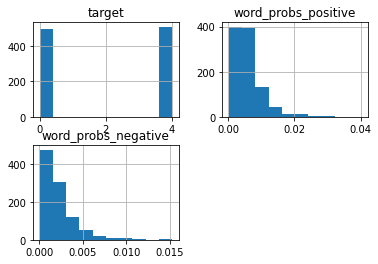

In [95]:
tweet_data[['target', 'word_probs_positive', 'word_probs_negative']].hist()

In [96]:
def normalize_df(df):
    return (df - df.mean())/df.std()

In [97]:
tweet_data[['target', 'word_probs_positive', 'word_probs_negative']]

,target,word_probs_positive,word_probs_negative
553603,0,0.006233,0.000355
1502709,4,0.003725,0.000265
904459,4,0.003291,0.001913
842167,4,0.002460,0.002118
1521976,4,0.013035,0.003782
...,...,...,...
54457,0,0.003152,0.002775
1206092,4,0.005249,0.003218
205977,0,0.006778,0.001658
491330,0,0.016188,0.006382


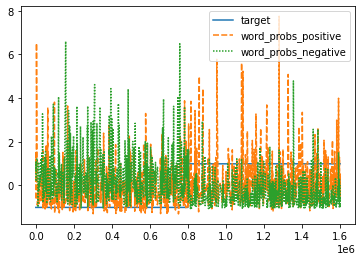

In [98]:
sns.lineplot(data = normalize_df(tweet_data[['target', 'word_probs_positive', 'word_probs_negative']]))

In [99]:
tweet_data['agg1'] = tweet_data['word_probs_positive'] / tweet_data['word_probs_negative']

In [100]:
tweet_data['agg2'] = tweet_data['word_probs_positive'] / (tweet_data['word_probs_positive'] + tweet_data['word_probs_negative'])

In [101]:
import numpy as np

In [102]:
tweet_data['agg3'] = np.arctan(tweet_data['word_probs_positive']/ tweet_data['word_probs_negative'])

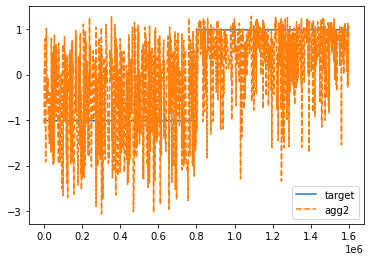

In [103]:
sns.lineplot(data = normalize_df(tweet_data[['target', 'agg2']]))

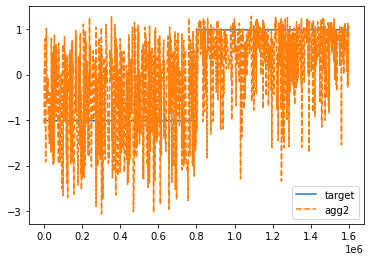

In [104]:
sns.lineplot(data = normalize_df(tweet_data[['target', 'agg2']]))

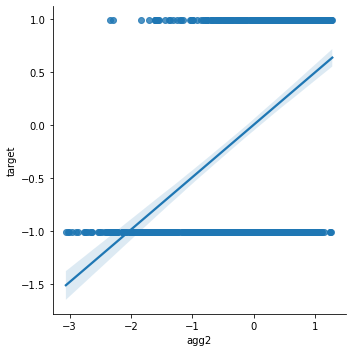

In [105]:
sns.lmplot(data = normalize_df(tweet_data[['target', 'agg2']]), x='agg2', y='target')

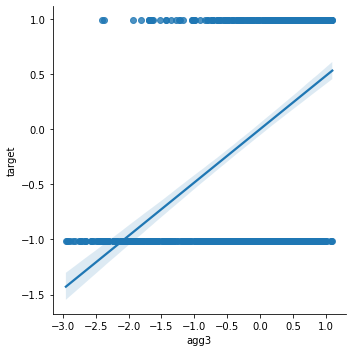

In [106]:
sns.lmplot(data = normalize_df(tweet_data[['target', 'agg3']]), x='agg3', y='target')

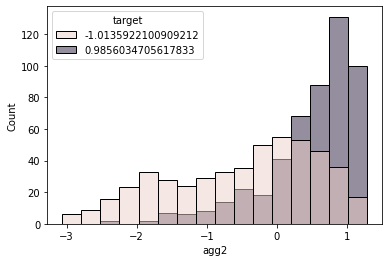

In [107]:
sns.histplot(data = normalize_df(tweet_data[['target', 'agg2']]), x = 'agg2', hue = 'target')

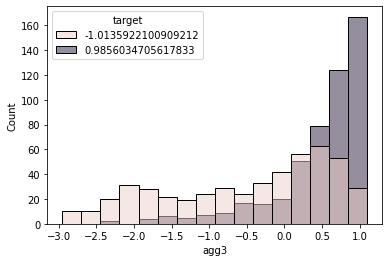

In [108]:
sns.histplot(data = normalize_df(tweet_data[['target', 'agg3']]), x = 'agg3', hue = 'target')

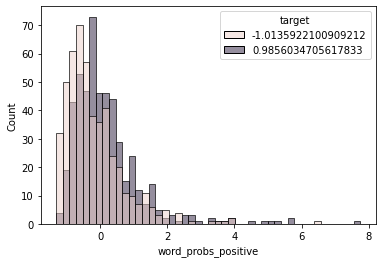

In [109]:
sns.histplot(data = normalize_df(tweet_data[['target', 'word_probs_positive']]), x = 'word_probs_positive', hue = 'target')

<ipython-input-96-13b883462a5b>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return (df - df.mean())/df.std()


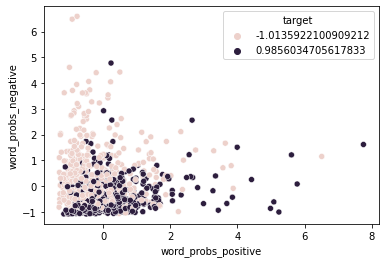

In [110]:
sns.scatterplot(data=normalize_df(tweet_data), x='word_probs_positive', y='word_probs_negative', hue='target')

In [111]:
tweet_data

,target,text,word_probs_positive,word_probs_negative,agg1,agg2,agg3
553603,0,aaronmillerillz jealous cool tshirts in the c...,0.006233,0.000355,17.572757,0.946158,1.513951
1502709,4,Finally donee wooooo; soooo anyway hope all o...,0.003725,0.000265,14.051770,0.933563,1.499751
904459,4,hueypriest guess that depends on if you want t...,0.003291,0.001913,1.720717,0.632450,1.044350
842167,4,johnculberson Me too John! We took our religio...,0.002460,0.002118,1.161486,0.537355,0.859970
1521976,4,ichasayangrudisayangichakamisalingmenyayangi ...,0.013035,0.003782,3.446772,0.775118,1.288422
...,...,...,...,...,...,...,...
54457,0,wAonLdeIrlCanEd he could have told me.,0.003152,0.002775,1.136137,0.531865,0.849042
1206092,4,MMR04 LOL whatever . ambers right u live in n...,0.005249,0.003218,1.631322,0.619963,1.020873
205977,0,IF I keep having these dream teases...it will ...,0.006778,0.001658,4.087081,0.803424,1.330837
491330,0,nickjonas I can't believe it... in my country ...,0.016188,0.006382,2.536543,0.717238,1.195268


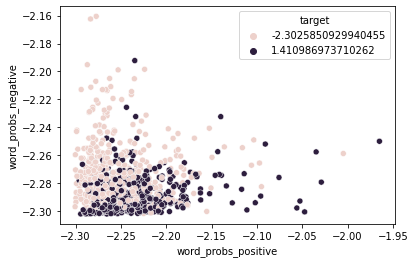

In [112]:
sns.scatterplot(data=np.log(0.1+np.abs(tweet_data[['word_probs_positive', 'word_probs_negative', 'target']])), x='word_probs_positive', y='word_probs_negative', hue='target')

In [113]:
from scipy.stats import pearsonr

In [114]:
pearsonr(tweet_data['target'], tweet_data['agg2'])

(0.49419775714949826, 1.0545281613037253e-62)

In [115]:
pearsonr(tweet_data['target'], tweet_data['agg3'])

(0.4838716187373018, 8.10974650376867e-60)

In [116]:
import sklearn.model_selection as sk_ms
import sklearn.neighbors as sk_ngbs
import sklearn.linear_model as sk_lm

In [117]:
clf_knn = sk_ngbs.KNeighborsClassifier(n_neighbors=100)
sk_ms.cross_validate(clf_knn, 
                     normalize_df(np.log(tweet_data[['word_probs_positive', 'word_probs_negative']])), 
                     tweet_data['target'], 
                     scoring='accuracy')['test_score'].mean()

0.7169999999999999

In [118]:
clf_knn.fit(np.log(tweet_data[['word_probs_positive', 'word_probs_negative']]), tweet_data['target'])

KNeighborsClassifier(n_neighbors=100)

In [119]:
clf_lm = sk_lm.LogisticRegression(penalty='none')
sk_ms.cross_validate(clf_lm, 
                     tweet_data[['word_probs_positive', 'word_probs_negative']], 
                     tweet_data['target'], 
                     scoring='accuracy')['test_score'].mean()

0.709

In [120]:
clf_lm.fit(np.array(tweet_data[['word_probs_positive', 'word_probs_negative']]), tweet_data['target'])

LogisticRegression(penalty='none')

In [121]:
clf_lm = sk_lm.LogisticRegression(penalty='none')
sk_ms.cross_validate(clf_lm, 
                     tweet_data[['agg2']], 
                     tweet_data['target'], 
                     scoring='accuracy')['test_score'].mean()

0.7220000000000001

In [122]:
clf_lm.fit(np.array(tweet_data[['agg2']]), tweet_data['target'])

LogisticRegression(penalty='none')

In [123]:
tweet_data_test = all_tweet_data.sample(1000)[['target', 'text']]

In [124]:
tweet_word_probs_test = tweet_data_test['text'].apply(lambda x : sentiment_probs_from_prompt(mt, x + '. I am'))
tweet_data_test['word_probs_positive'] = tweet_word_probs_test.apply(lambda x : x[0])
tweet_data_test['word_probs_negative'] = tweet_word_probs_test.apply(lambda x : x[1])

tweet_data_test['agg2'] = tweet_data_test['word_probs_positive'] / (tweet_data_test['word_probs_positive'] + tweet_data_test['word_probs_negative'])

In [125]:
import sklearn.metrics as sk_metrics

In [126]:
sk_metrics.accuracy_score(tweet_data_test['target'], clf_lm.predict(np.array(tweet_data_test['agg2']).reshape(-1,1)))

0.684

In [127]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None, target_predictor=(lambda x : 0.5)
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
        answer_t = [922, 2089]

    answer = 'pos_sent'
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise, target_predictor=target_predictor
    )
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise, target_predictor=target_predictor
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
            target_predictor=target_predictor
        )
    #differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1, target_predictor=lambda x : 0.5):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
                target_predictor=target_predictor
            )
            row.append(r)
        table.append(row)
    return np.array(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1, target_predictor=lambda x : 0.5
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise, target_predictor=target_predictor
            )
            row.append(r)
        table.append(row)
    return np.array(table)

In [128]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

torch.set_grad_enabled(False)

In [129]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
    target_predictor=(lambda x : 0.5)
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return target_predictor(probs.cpu().numpy().reshape(1, -1))

In [130]:
res = calculate_hidden_flow(mt, 'I am happy so i feel', subject='I am',  target_predictor=lambda x : clf_lm.predict_proba([[x[0][0]/(x[0][0] + x[0][1])]])[0,1])

In [131]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
    target_predictor=None
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind, target_predictor=target_predictor
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)



In [133]:
#plot_hidden_flow(mt, "I am happy, I am feeling ", subject='I am happy', target_predictor=lambda x : clf_lm.predict_proba(x)[0,1])

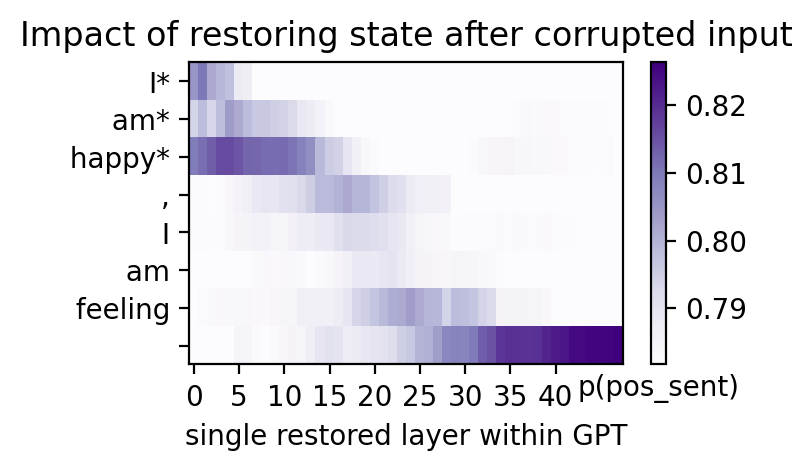

In [134]:
plot_hidden_flow(mt, "I am happy, I am feeling ", subject='I am happy', target_predictor=lambda x : clf_lm.predict_proba([[x[0][0]/(x[0][0] + x[0][1])]])[0,1])

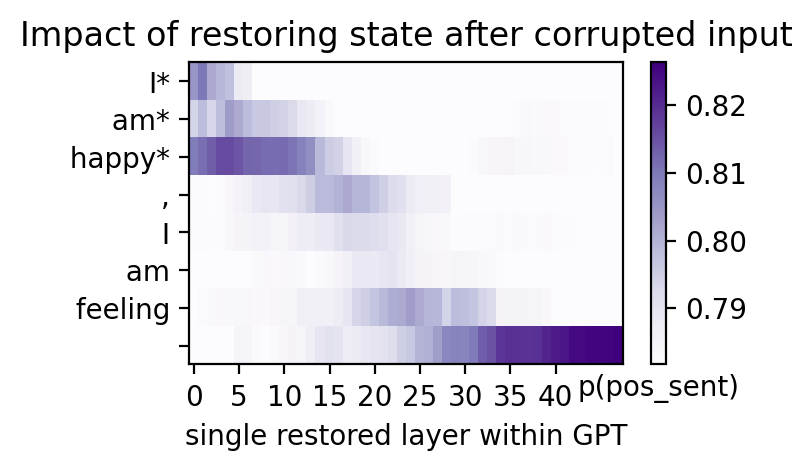

In [135]:
plot_hidden_flow(mt, "I am happy, I am feeling ", subject='I am happy', target_predictor=lambda x : clf_lm.predict_proba([[x[0][0]/(x[0][0] + x[0][1])]])[0,1])

In [136]:
def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None, target_predictor=lambda x : 0.5):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind, target_predictor=target_predictor
        )

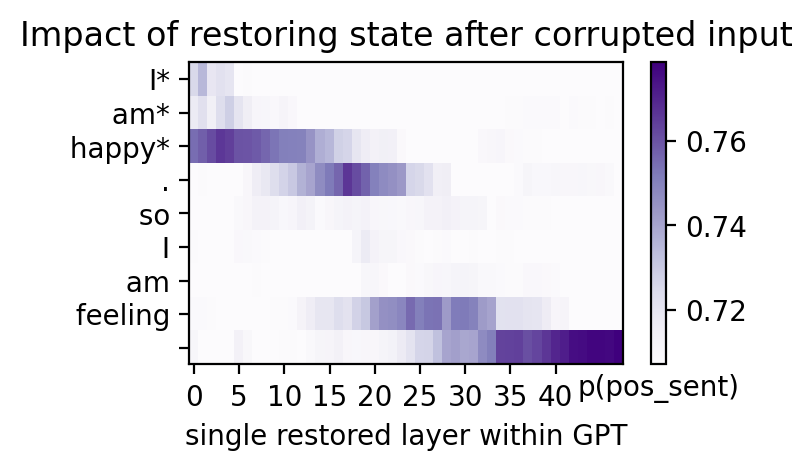

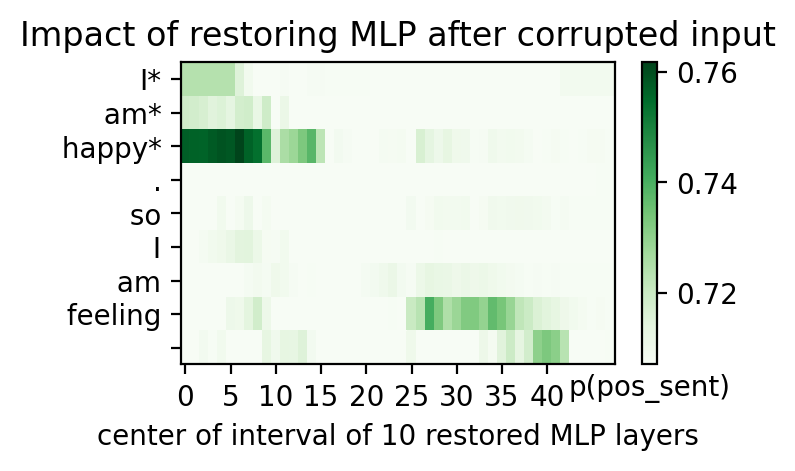

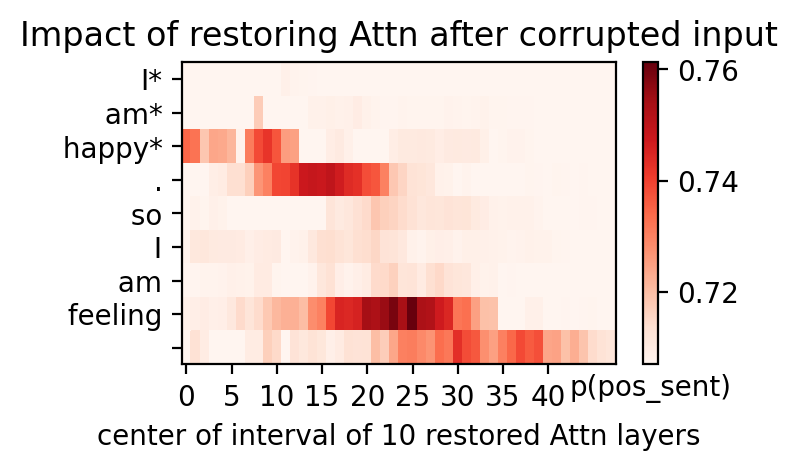

In [137]:
plot_all_flow(mt, "I am happy. so I am feeling ", subject='I am happy', target_predictor=lambda x : clf_lm.predict_proba([[x[0][0]/(x[0][0] + x[0][1])]])[0,1])

In [ ]:
clf_lm.predict_proba(trace_with_patch(mt.model, inp, [], answer_t, [1,2], target_predictor=clf_lm.predict_proba).reshape(1, -1))

In [ ]:
trace_with_patch(mt.model, inp, [], answer_t, [1,2]).item()


In [ ]:
type(trace_with_patch(mt.model, inp, [], answer_t, [1,2]))

In [139]:
trace_tweet_data = all_tweet_data.sample(5)[['target', 'text']]

# remove @ symbols
trace_tweet_data['text'] = trace_tweet_data['text'].apply(lambda x : x.replace('@', ''))

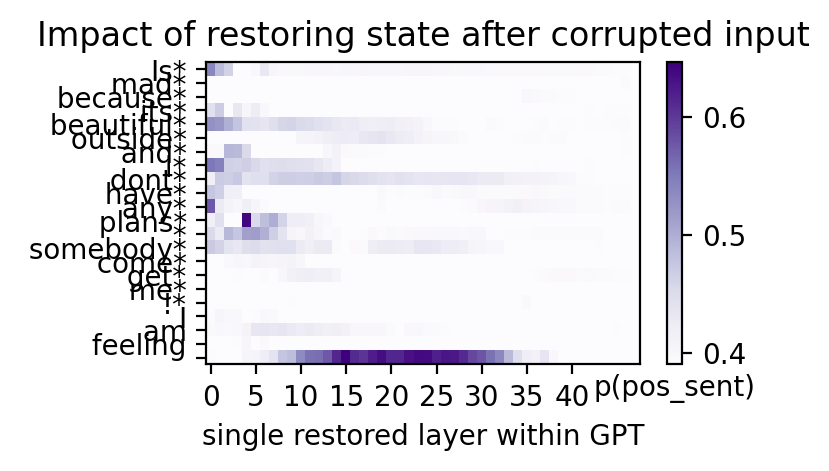

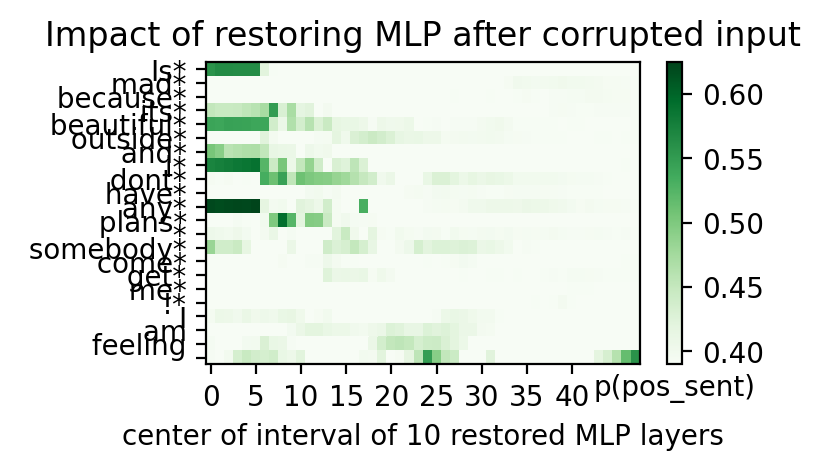

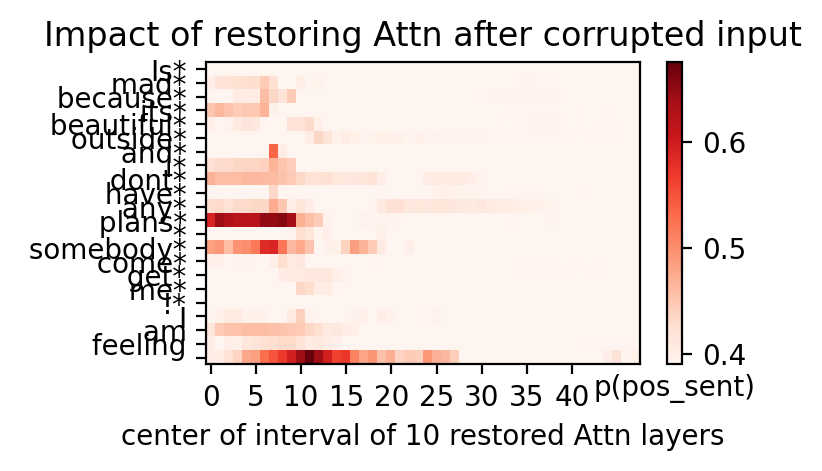

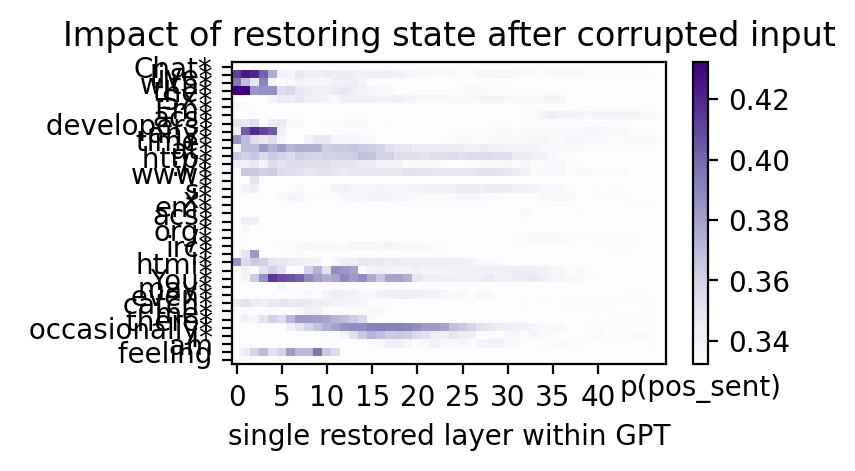

KeyboardInterrupt: ignored

In [140]:
for tweet_text in trace_tweet_data['text']:
    plot_all_flow(mt, tweet_text + 'I am feeling ', subject=tweet_text, target_predictor=lambda x : clf_lm.predict_proba([[x[0][0]/(x[0][0] + x[0][1])]])[0,1] )

In [ ]:
for tweet_text in trace_tweet_data['text']:
    plot_all_flow(mt, tweet_text + 'I am feeling ', subject=tweet_text, target_predictor=lambda x : (x[0][0]/(x[0][0] + x[0][1])) )